In [1]:
! unzip Sarcasm_Headlines_Dataset.json.zip

Archive:  Sarcasm_Headlines_Dataset.json.zip
  inflating: Sarcasm_Headlines_Dataset.json  


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
import matplotlib.pyplot as plt

In [3]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


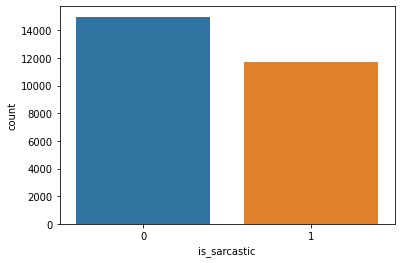

In [4]:
sns.countplot(x='is_sarcastic', data=df)

In [5]:
print(df.is_sarcastic.value_counts())
print('----------------------------------')
print('total = ' + str(len(df.is_sarcastic)))

0    14985
1    11724
Name: is_sarcastic, dtype: int64
----------------------------------
total = 26709


In [6]:
x = df.iloc[:,1]
y = df.iloc[:,2]
print('x')
print(x)
print('y')
print(y)

x
0        former versace store clerk sues over secret 'b...
1        the 'roseanne' revival catches up to our thorn...
2        mom starting to fear son's web series closest ...
3        boehner just wants wife to listen, not come up...
4        j.k. rowling wishes snape happy birthday in th...
                               ...                        
26704                 american politics in moral free-fall
26705                              america's best 20 hikes
26706                                reparations and obama
26707    israeli ban targeting boycott supporters raise...
26708                    gourmet gifts for the foodie 2014
Name: headline, Length: 26709, dtype: object
y
0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

21367
5342
21367
5342


In [8]:
max_wrd = 1000
max_len = 150
tok = Tokenizer(num_words = max_wrd)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
sequences_matrix.shape

(21367, 150)

In [9]:
sequences_matrix

array([[  0,   0,   0, ...,   8,  95, 130],
       [  0,   0,   0, ...,   7, 232, 151],
       [  0,   0,   0, ..., 194,   9, 260],
       ...,
       [  0,   0,   0, ..., 456,   2,  31],
       [  0,   0,   0, ...,  52, 193, 134],
       [  0,   0,   0, ...,   7,  30,  60]], dtype=int32)

In [10]:
np.amax(sequences_matrix)

999

In [11]:
def RNN():
  inputs = Input(name='inputs', shape=[max_len])
  embed = Embedding(max_wrd, 50, input_length = max_len)(inputs) #50 is the output dimension of the embeddings
  lstm = LSTM(64)(embed)
  dense1 = Dense(256, name='FC1')(lstm)
  relu = Activation('relu')(dense1)
  drop = Dropout(0.2)(relu)
  dense2 = Dense(1, name = 'out_layer')(drop)
  outputs = Activation('sigmoid')(dense2)
  model = Model(inputs = inputs, outputs = outputs)
  return model

In [13]:
model = RNN()
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [39]:
history = model.fit(sequences_matrix, y_train,
                    batch_size = 100, epochs = 50, validation_split = 0.1)

Epoch 1/50
193/193 [==============================] - 5s 15ms/step - loss: 0.5429 - accuracy: 0.6984 - val_loss: 0.4034 - val_accuracy: 0.8133
Epoch 2/50
193/193 [==============================] - 2s 12ms/step - loss: 0.3799 - accuracy: 0.8315 - val_loss: 0.4748 - val_accuracy: 0.7688
Epoch 3/50
193/193 [==============================] - 2s 13ms/step - loss: 0.8634 - accuracy: 0.7572 - val_loss: 0.4206 - val_accuracy: 0.8095
Epoch 4/50
193/193 [==============================] - 2s 12ms/step - loss: 0.3874 - accuracy: 0.8285 - val_loss: 0.4210 - val_accuracy: 0.7861
Epoch 5/50
193/193 [==============================] - 2s 13ms/step - loss: 0.3665 - accuracy: 0.8382 - val_loss: 0.3937 - val_accuracy: 0.8269
Epoch 6/50
193/193 [==============================] - 2s 12ms/step - loss: 0.3246 - accuracy: 0.8561 - val_loss: 0.4010 - val_accuracy: 0.8180
Epoch 7/50
193/193 [==============================] - 2s 12ms/step - loss: 0.3204 - accuracy: 0.8559 - val_loss: 0.3908 - val_accuracy: 0.8278

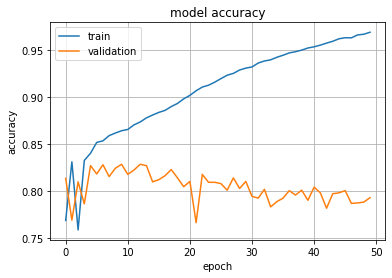

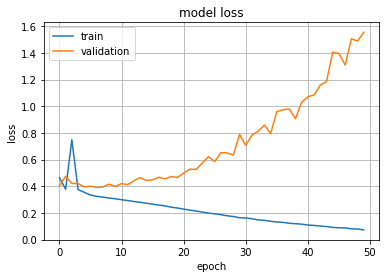

In [42]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
test_sequences_matrix.shape

(5342, 150)

In [49]:
accuracy = model.evaluate(test_sequences_matrix, y_test)
print('Test set')
print('Loss: ' + str(accuracy[0]))
print('Accuracy: ' + str(accuracy[1]))

167/167 [==============================] - 1s 5ms/step - loss: 1.5647 - accuracy: 0.7857
Test set
Loss: 1.564742088317871
Accuracy: 0.7856608033180237


In [17]:
model2 = RNN()
model2.summary()
model2.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])
history2 = model2.fit(sequences_matrix, y_train,
                      batch_size = 100, epochs = 10, validation_split = 0.1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

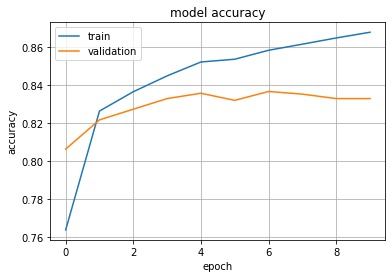

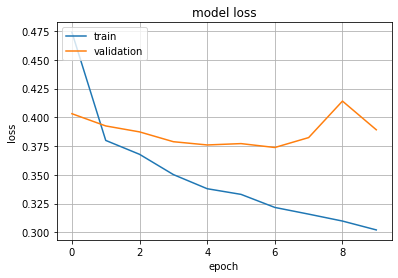

In [18]:
fig = plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
accuracy2 = model.evaluate(test_sequences_matrix, y_test)
print('Test set')
print('Loss: ' + str(accuracy2[0]))
print('Accuracy: ' + str(accuracy2[1]))

167/167 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.4272
Test set
Loss: 0.6934959888458252
Accuracy: 0.42718082666397095


In [14]:
model3 = RNN()
model3.summary()
model3.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])
history3 = model3.fit(sequences_matrix, y_train,
                      batch_size = 100, epochs = 5, validation_split = 0.1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

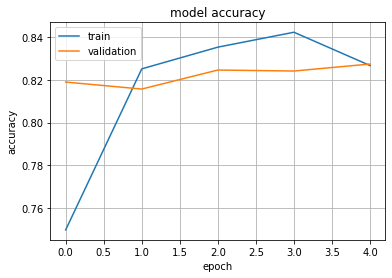

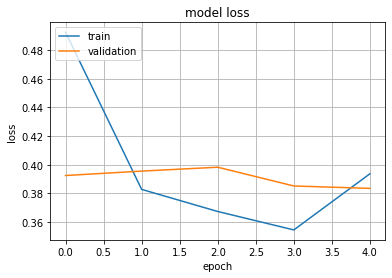

In [15]:
fig = plt.figure()
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
accuracy3 = model.evaluate(test_sequences_matrix, y_test)
print('Test set')
print('Loss: ' + str(accuracy3[0]))
print('Accuracy: ' + str(accuracy3[1]))

167/167 [==============================] - 2s 6ms/step - loss: 0.6935 - accuracy: 0.4281
Test set
Loss: 0.6934959888458252
Accuracy: 0.42718082666397095
